<a href="https://colab.research.google.com/github/fediAou/Classification-of-the-UCM-dataset-using-ResNet50V2-Model/blob/main/UCM_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import os
from glob import glob
from natsort import natsorted
import pandas as pd
import tifffile
import datetime, os

import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from sklearn.utils import shuffle

%load_ext tensorboard

## Visualisation

In [ ]:
# walk through the data folder
DATA_DIR = "/content/drive/MyDrive/UCMerced_LandUse"
for dirpath, dirnames, filenames in os.walk(DATA_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 2 images in '/content/drive/MyDrive/UCMerced_LandUse'.
There are 21 directories and 0 images in '/content/drive/MyDrive/UCMerced_LandUse/Images'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/runway'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/parkinglot'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/sparseresidential'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/storagetanks'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/mediumresidential'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/river'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/tenniscourt'.
There are 0 directories and 100 images in '/content/drive/MyDrive/UCMerced_LandUse/Images/overpas

In [ ]:
class_names = [
    "agricultural",
    "airplane",
    "baseballdiamond",
    "beach",
    "buildings",
    "chaparral",
    "denseresidential",
    "forest",
    "freeway",
    "golfcourse",
    "harbor",
    "intersection",
    "mediumresidential",
    "mobilehomepark",
    "overpass",
    "parkinglot",
    "river",
    "runway",
    "sparseresidential",
    "storagetanks",
    "tenniscourt",
]

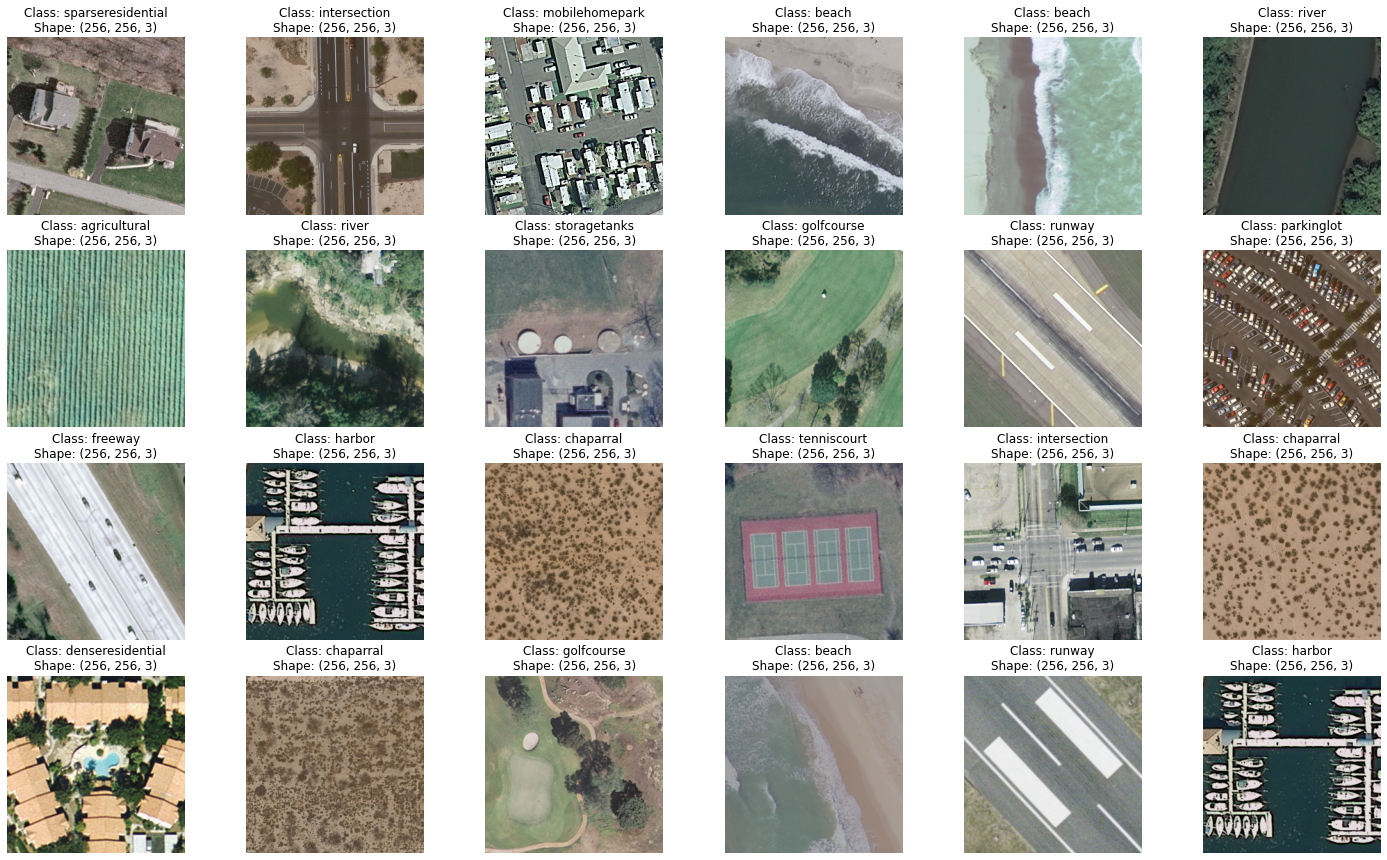

In [ ]:
# visualize some samples of the dataset
plt.figure(figsize=(25,15))
DATA_FOLDER = "/content/drive/MyDrive/UCMerced_LandUse/Images"

for i in range(24):
  plt.subplot(4, 6, i+1)

  random_index = random.randint(10, 98)
  random_class = random.choice(class_names)

  random_path = DATA_FOLDER + "/" + random_class + "/" + random_class + str(random_index) + ".tif"
  random_img = mpimg.imread(random_path)
  plt.imshow(random_img)

  plt.axis(False)

  plt.title(f"Class: {random_class}\nShape: {random_img.shape}")

## Preparing the data

In [ ]:
path_images = "/content/drive/MyDrive/UCMerced_LandUse/Images"


list_images = glob(os.path.join(path_images,"**","*.tif"), recursive=True)
list_images = natsorted(list_images, key=lambda y: y.lower())

df = pd.DataFrame(list_images, columns=["path_image"])

df["class"] = df["path_image"].apply(lambda x: x.split("/")[-2])

classes = np.unique(df["class"].values)
classes_int = np.arange(len(classes))
classes_dict = dict(zip(classes, classes_int))
num_classes = len(classes)

df["class_int"] = df["class"].apply(lambda x: classes_dict[x])

df.head()

,path_image,class,class_int
0,/content/drive/MyDrive/UCMerced_LandUse/Images...,agricultural,0
1,/content/drive/MyDrive/UCMerced_LandUse/Images...,agricultural,0
2,/content/drive/MyDrive/UCMerced_LandUse/Images...,agricultural,0
3,/content/drive/MyDrive/UCMerced_LandUse/Images...,agricultural,0
4,/content/drive/MyDrive/UCMerced_LandUse/Images...,agricultural,0


## Splitting the data into Train, Val and Test

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(df["path_image"].values,
                                                    df["class_int"].values,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    stratify=df["class_int"].values)

train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                  train_labels,
                                                  train_size=0.75,
                                                  test_size=0.25,
                                                  stratify=train_labels)

## Class DataGenerator

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 batch_size,
                 path_images,
                 labels,
                 n_classes,
                 img_size=256,
                 shuffle=True):
        self.batch_size = batch_size
        self.path_images = path_images
        self.labels = labels
        self.n_classes = n_classes
        self.img_size=img_size
        self.shuffle= shuffle

    def on_epoch_end(self):
        if self.shuffle:
            self.path_images, self.labels = shuffle(self.path_images, self.labels)

    def __len__(self):
        return self.path_images.shape[0]//self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size

        batch_images = self.path_images[i : i + self.batch_size]
        batch_labels = self.labels[i : i + self.batch_size]

        x = np.zeros((self.batch_size,
                      self.img_size,
                      self.img_size,
                      3),
                      dtype=np.float32)

        y = np.zeros((self.batch_size,
                      self.n_classes,
                      1),
                      dtype=np.float32)


        for j, filename_image in enumerate(batch_images):

            x_sample = tifffile.imread(filename_image)
            x_sample = np.resize(x_sample,(self.img_size,self.img_size,3))
            x_sample = np.expand_dims(x_sample, axis=0)
            x_sample = x_sample.astype("float")/255

            y_sample = to_categorical(batch_labels[j], num_classes=self.n_classes)
            y_sample = np.expand_dims(y_sample, axis=-1)

            x[j,...] = x_sample
            y[j,...] = y_sample

        return x, y

## Applaying DataGenerator for train and val data

In [ ]:
batch_size = 32

train_datagen = DataGenerator(batch_size=batch_size,
                               path_images=train_data,
                               labels=train_labels,
                               n_classes=num_classes)

val_datagen = DataGenerator(batch_size=batch_size,
                             path_images=val_data,
                             labels=val_labels,
                             n_classes=num_classes)

In [ ]:
# Create checkoints
checkpoint_path = "/content/drive/MyDrive/UCM_Data_resnet/model_checkpoints/cp.ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  verbose=1)

In [ ]:
# TensorBoard
logdir = os.path.join("logs", "resnet_UCM")
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
%tensorboard --logdir logs

## ResNet50V2

In [ ]:
def get_resnet_model(n_classes, img_size=256):

    base_model = ResNet50V2(weights="imagenet",
                       include_top=False,
                       input_shape=(img_size,img_size,3),
                       classes=num_classes
                       )

    base_model.trainable = False

    model = Sequential([base_model,
                        Flatten(),
                        Dense(num_classes, activation="softmax")]
                       )

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )

    return model

In [ ]:
resnet_model = get_resnet_model(n_classes=num_classes)
resnet_model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 21)                2752533   
                                                                 
Total params: 26,317,333
Trainable params: 2,752,533
Non-trainable params: 23,564,800
_________________________________________________________________


## Fit the model

In [ ]:
history = resnet_model.fit(train_datagen,
                                 epochs=20,
                                 steps_per_epoch=len(train_data)//batch_size,
                                 validation_data=val_datagen,
                                 validation_steps=len(val_data)//batch_size,
                                 callbacks=[model_checkpoint, tensorboard_callback])

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 4.0581 - accuracy: 0.7212 
Epoch 1: val_loss improved from inf to 1.37245, saving model to /content/drive/MyDrive/UCM_Data_resnet/model_checkpoints/cp.ckpt
39/39 [==============================] - 960s 25s/step - loss: 4.0581 - accuracy: 0.7212 - val_loss: 1.3725 - val_accuracy: 0.8966
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9776
Epoch 2: val_loss did not improve from 1.37245
39/39 [==============================] - 309s 8s/step - loss: 0.2139 - accuracy: 0.9776 - val_loss: 1.7539 - val_accuracy: 0.8726
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9936
Epoch 3: val_loss did not improve from 1.37245
39/39 [==============================] - 308s 8s/step - loss: 0.0620 - accuracy: 0.9936 - val_loss: 1.4403 - val_accuracy: 0.9062
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9944
Epoch 4: 

In [ ]:
# Evaluation
test_datagen = DataGenerator(batch_size=batch_size,
                             path_images=test_data,
                             labels=test_labels,
                             n_classes=num_classes,)

resnet_model.evaluate(test_datagen)

13/13 [==============================] - 233s 19s/step - loss: 2.2854 - accuracy: 0.8918


[2.2853732109069824, 0.8918269276618958]